In [3]:
# Install quantum libs
!pip install -q qiskit qiskit-machine-learning pennylane pennylane-qiskit torch qiskit-aer qiskit-algorithms



In [4]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Classical ML
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc
)

# TensorFlow Autoencoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Qiskit
from qiskit_aer import Aer
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# PennyLane
import pennylane as qml

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)


In [5]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

BASE_PATH = "/content/drive/MyDrive"
DATA_DIR = BASE_PATH  # Corrected: files are directly in MyDrive, not in a 'datasets' subfolder

def load_csv(file_name, base_path=DATA_DIR):
    path = os.path.join(base_path, file_name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path)
    print(f"Loaded {file_name}: shape={df.shape}")
    return df

df_train = load_csv("part1.csv")
df_test2 = load_csv("part2.csv")
df_test3 = load_csv("part3.csv")

Mounted at /content/drive
Loaded part1.csv: shape=(94936, 31)
Loaded part2.csv: shape=(94936, 31)
Loaded part3.csv: shape=(94935, 31)


=== Dataset Shapes ===
Part1 (Train): (94936, 31)
Part2 (Test2): (94936, 31)
Part3 (Test3): (94935, 31)

=== Column Names ===
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

=== Class distribution: Part1 (Train) ===
Class
0    94719
1      217
Name: count, dtype: int64
Fraud percentage: 0.2286 %

=== Class distribution: Part2 (Test2) ===
Class
0    94783
1      153
Name: count, dtype: int64
Fraud percentage: 0.1612 %

=== Class distribution: Part3 (Test3) ===
Class
0    94813
1      122
Name: count, dtype: int64
Fraud percentage: 0.1285 %

=== Combined dataset shape ===
(284807, 31)

=== Class distribution: Combined ===
Class
0    284315
1       492
Name: count, dtype: int64
Fraud percentage: 0.1727 %

=== Missing Values (All Data) ===
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7

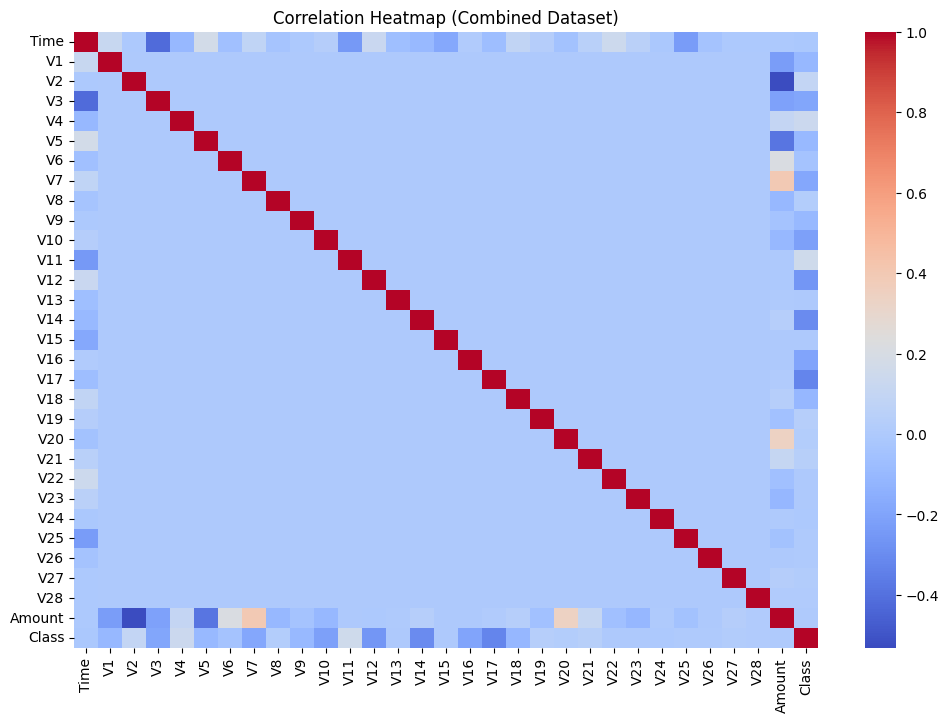

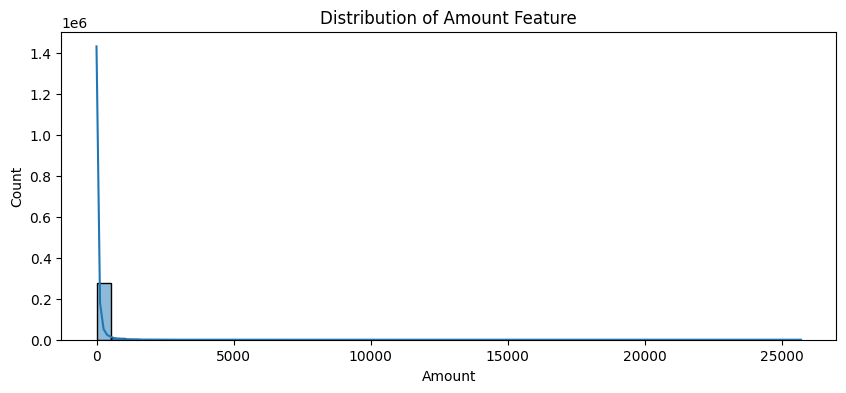

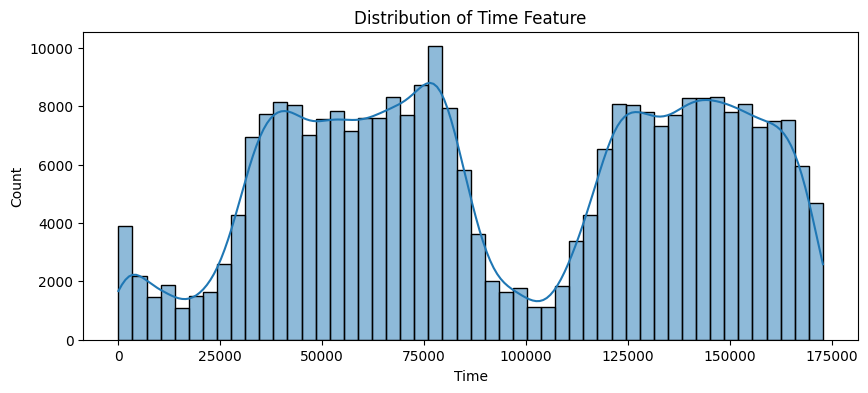


=== Data inspection completed ===


In [19]:
# ======================================================
# DATA INSPECTION & INFORMATION REPORT
# Works with df_train, df_test2, df_test3
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Basic shapes and counts
# --------------------------

print("=== Dataset Shapes ===")
print(f"Part1 (Train): {df_train.shape}")
print(f"Part2 (Test2): {df_test2.shape}")
print(f"Part3 (Test3): {df_test3.shape}")

print("\n=== Column Names ===")
print(df_train.columns.tolist())

# --------------------------
# 2. Class distribution
# --------------------------

def class_info(name, df):
    print(f"\n=== Class distribution: {name} ===")
    counts = df["Class"].value_counts()
    print(counts)
    print("Fraud percentage:", round(counts[1] / len(df) * 100, 4), "%")

class_info("Part1 (Train)", df_train)
class_info("Part2 (Test2)", df_test2)
class_info("Part3 (Test3)", df_test3)

# Combined dataset
df_combined = pd.concat([df_train, df_test2, df_test3], ignore_index=True)
print("\n=== Combined dataset shape ===")
print(df_combined.shape)
class_info("Combined", df_combined)

# --------------------------
# 3. Missing values
# --------------------------
print("\n=== Missing Values (All Data) ===")
print(df_combined.isnull().sum())

# --------------------------
# 4. Duplicate rows
# --------------------------
duplicates = df_combined.duplicated().sum()
print(f"\n=== Number of Duplicate Rows: {duplicates} ===")

# --------------------------
# 5. Descriptive statistics
# --------------------------
print("\n=== Descriptive Statistics (First 10 columns) ===")
print(df_combined.describe().iloc[:, :10])

# --------------------------
# 6. Data types
# --------------------------
print("\n=== Data Types ===")
print(df_combined.dtypes)

# --------------------------
# 7. Correlation heatmap (optional)
# --------------------------

plt.figure(figsize=(12, 8))
sns.heatmap(df_combined.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Combined Dataset)")
plt.show()

# --------------------------
# 8. Feature distribution example
# --------------------------
plt.figure(figsize=(10, 4))
sns.histplot(df_combined["Amount"], bins=50, kde=True)
plt.title("Distribution of Amount Feature")
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df_combined["Time"], bins=50, kde=True)
plt.title("Distribution of Time Feature")
plt.show()

print("\n=== Data inspection completed ===")


In [6]:
def calculate_threshold(scores, method="percentile", percentile=97):
    scores = np.asarray(scores)

    if method == "percentile":
        return np.percentile(scores, percentile)
    elif method == "std":
        return np.mean(scores) + 2 * np.std(scores)
    elif method == "iqr":
        q1, q3 = np.percentile(scores, [25, 75])
        iqr = q3 - q1
        return q3 + 1.5 * iqr
    else:
        raise ValueError(f"Unsupported threshold method: {method}")

def normalize_scores(scores):
    scores = np.asarray(scores)
    smin, smax = np.min(scores), np.max(scores)
    return (scores - smin) / (smax - smin + 1e-12)

def evaluate_model(name, y_true, y_pred):
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    roc  = roc_auc_score(y_true, y_pred)

    print(f"\n=== {name} ===")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    return {"precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}

def plot_curves(name, y_true, scores):
    scores = np.asarray(scores)

    # PR curve
    prec, rec, _ = precision_recall_curve(y_true, scores)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=name)
    plt.title(f"{name} Precision–Recall Curve")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(); plt.grid(True); plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc_val = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_val:.3f})")
    plt.plot([0,1],[0,1],"k--")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.grid(True); plt.show()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 3)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Dense)          │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,353 (32.63 KB)

 Trainable params: 8,353 (32.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.9272 - val_loss: 0.7365 - learning_rate: 0.0010
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7935 - val_loss: 0.6701 - learning_rate: 0.0010
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7358 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 4/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.7058 - val_loss: 0.5951 - learning_rate: 0.0010
Epoch 5/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6766 - val_loss: 0.5652 - learning_rate: 0.0010
Epoch 6/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6553 - val_loss: 0.5417 - learning_rate: 0.0010
Epoch 7/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6424 - val_loss: 0.5277 - learning_rate: 0.0010
Epoch 8/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6286 - val_loss: 0.5166 - learning_rate: 0.0010
Epoch 9/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6238 - val_loss: 0.5087 - learning_rate: 0.0010


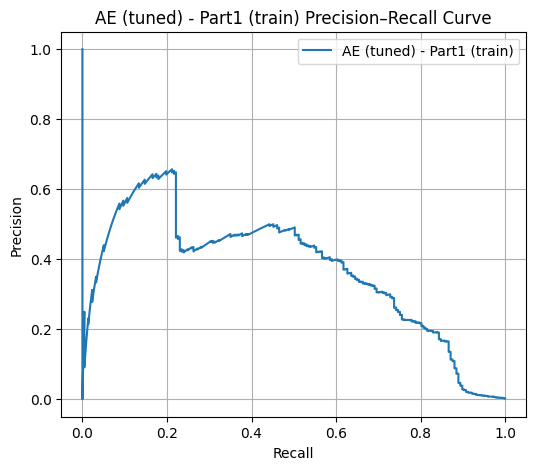

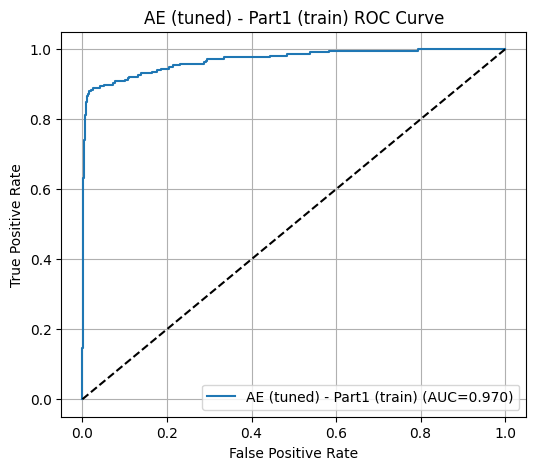


=== Autoencoder (tuned) - Part2 (test2) ===

=== AE (tuned) - Part2 (test2) ===
Precision: 0.4080
Recall:    0.5359
F1-score:  0.4633
ROC-AUC:   0.7673

Confusion matrix:
[[94664   119]
 [   71    82]]

Classification report:
              precision    recall  f1-score   support

           0     0.9993    0.9987    0.9990     94783
           1     0.4080    0.5359    0.4633       153

    accuracy                         0.9980     94936
   macro avg     0.7036    0.7673    0.7311     94936
weighted avg     0.9983    0.9980    0.9981     94936



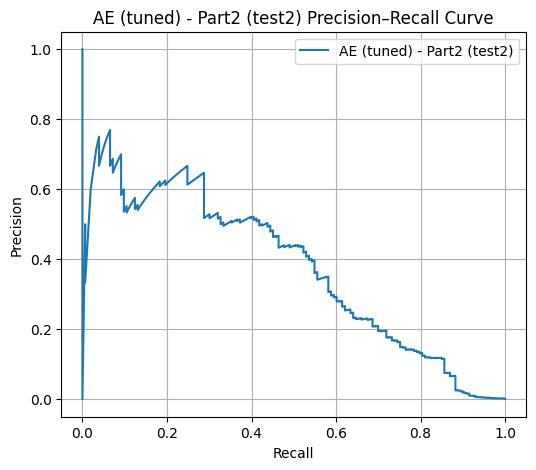

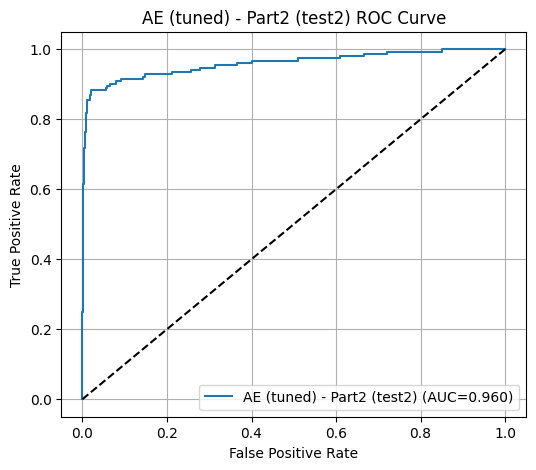


=== Autoencoder (tuned) - Part3 (test3) ===

=== AE (tuned) - Part3 (test3) ===
Precision: 0.1031
Recall:    0.1639
F1-score:  0.1266
ROC-AUC:   0.5810

Confusion matrix:
[[94639   174]
 [  102    20]]

Classification report:
              precision    recall  f1-score   support

           0     0.9989    0.9982    0.9985     94813
           1     0.1031    0.1639    0.1266       122

    accuracy                         0.9971     94935
   macro avg     0.5510    0.5810    0.5626     94935
weighted avg     0.9978    0.9971    0.9974     94935



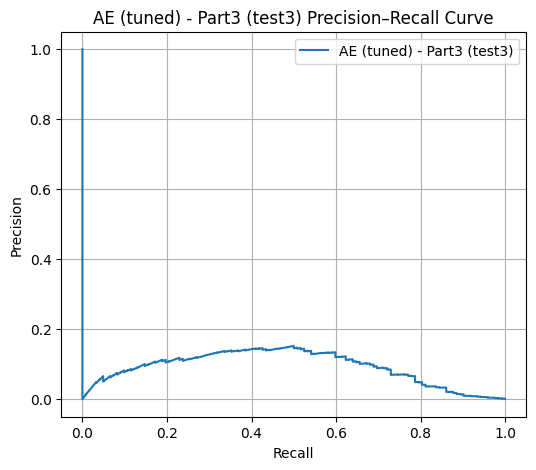

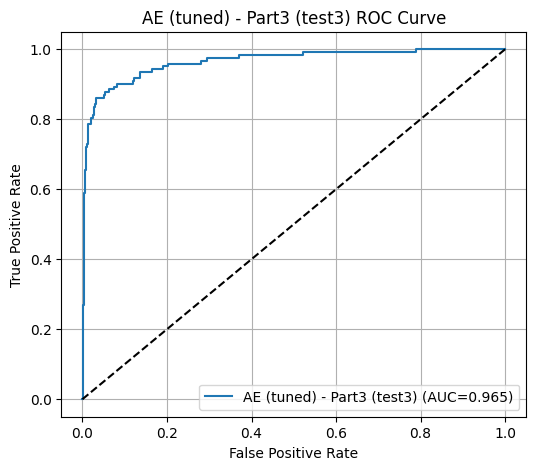

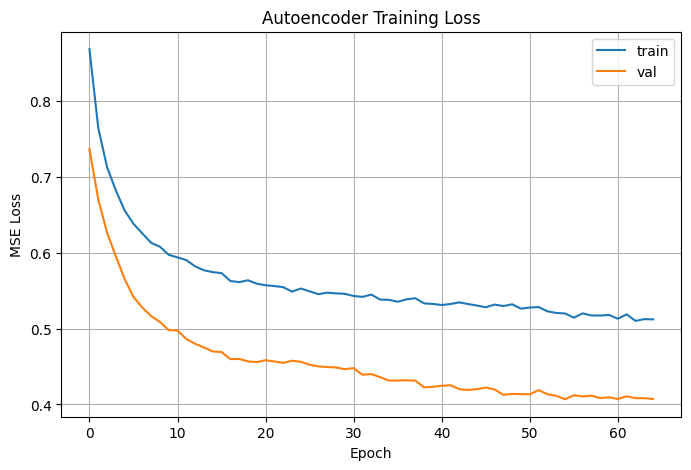

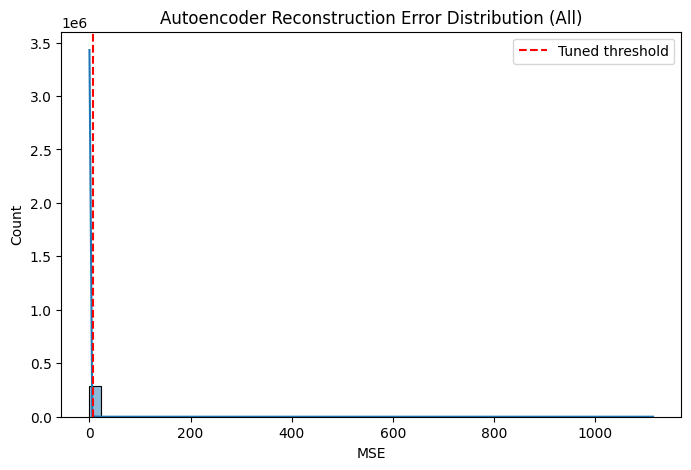

Bottleneck shape: (284807, 3)


In [7]:
#Autoencoder#
# == Combine data and scale ==
df_combined = pd.concat([df_train, df_test2, df_test3], ignore_index=True)

X = df_combined.drop(columns=["Class"])
y_true = df_combined["Class"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define split indices
n_train = len(df_train)
n_test2 = len(df_test2)
n_test3 = len(df_test3)

idx_train = slice(0, n_train)
idx_test2 = slice(n_train, n_train + n_test2)
idx_test3 = slice(n_train + n_test2, n_train + n_test2 + n_test3)

# == Autoencoder definition ==
input_dim = X_scaled.shape[1]

inp = Input(shape=(input_dim,), name="ae_input")

# Encoder
x = Dense(64, activation="relu")(inp)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)

latent = Dense(3, activation="relu", name="latent")(x)

# Decoder
x = Dense(32, activation="relu")(latent)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

out = Dense(input_dim, activation="linear", name="reconstruction")(x)

autoencoder = Model(inputs=inp, outputs=out, name="autoencoder")
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

autoencoder.summary()

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

# == Train AE on NORMAL samples from PART 1 only ==
train_mask = np.zeros_like(y_true, dtype=bool)
train_mask[idx_train] = True
normal_train_mask = (y_true == 0) & train_mask

X_train_ae = X_scaled[normal_train_mask]   # only normals from part1
X_all      = X_scaled                      # evaluate on all parts

history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    shuffle=True,
    verbose=1
)

# == Reconstruction error on ALL data ==
reconstructed = autoencoder.predict(X_all, verbose=0)
ae_mse = np.mean((X_all - reconstructed) ** 2, axis=1)

# === Threshold tuning using ONLY PART 1 ===
scores_train = ae_mse[idx_train]
labels_train = y_true[idx_train]

percentiles = np.linspace(90, 99.9, 50)  # search 90% → 99.9%
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train, p)
    preds = (scores_train > thr).astype(int)
    prec = precision_score(labels_train, preds, zero_division=0)
    rec  = recall_score(labels_train, preds, zero_division=0)
    f1   = f1_score(labels_train, preds, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[AE threshold tuning (Part1 only)]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

ae_thresh = best_thr
y_pred_ae_all = (ae_mse > ae_thresh).astype(int)

print(f"\nAE MSE threshold (tuned): {ae_thresh:.4f}")
print(f"Total AE anomalies: {(y_pred_ae_all == 1).sum()} / {len(y_pred_ae_all)}")

# == Metrics per part ==
def eval_ae_split(name, sl):
    y_split = y_true[sl]
    s_split = ae_mse[sl]
    y_pred_split = y_pred_ae_all[sl]
    print(f"\n=== Autoencoder (tuned) - {name} ===")
    _ = evaluate_model(f"AE (tuned) - {name}", y_split, y_pred_split)
    plot_curves(f"AE (tuned) - {name}", y_split, s_split)

eval_ae_split("Part1 (train)", idx_train)
eval_ae_split("Part2 (test2)", idx_test2)
eval_ae_split("Part3 (test3)", idx_test3)

# Training loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.grid(True); plt.show()

# Reconstruction error distribution (all data)
plt.figure(figsize=(8,5))
sns.histplot(ae_mse, bins=50, kde=True)
plt.axvline(ae_thresh, color="red", linestyle="--", label="Tuned threshold")
plt.title("Autoencoder Reconstruction Error Distribution (All)")
plt.xlabel("MSE"); plt.ylabel("Count")
plt.legend(); plt.show()

# == Bottleneck features for downstream models ==
encoder_model = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent").output
)
X_bottleneck = encoder_model.predict(X_all, verbose=0)
print("Bottleneck shape:", X_bottleneck.shape)



[IF threshold tuning (Part1 only)]
Best percentile: 99.50
Best threshold:  -0.0283
Precision:       0.2067
Recall:          0.4562
F1-score:        0.2845

IF score threshold (tuned): -0.0283
Total IF anomalies: 1255 / 284807

=== Isolation Forest (tuned) - Part1 (train) ===

=== IF (tuned) - Part1 (train) ===
Precision: 0.2067
Recall:    0.4562
F1-score:  0.2845
ROC-AUC:   0.7261

Confusion matrix:
[[94339   380]
 [  118    99]]

Classification report:
              precision    recall  f1-score   support

           0     0.9988    0.9960    0.9974     94719
           1     0.2067    0.4562    0.2845       217

    accuracy                         0.9948     94936
   macro avg     0.6027    0.7261    0.6409     94936
weighted avg     0.9969    0.9948    0.9957     94936



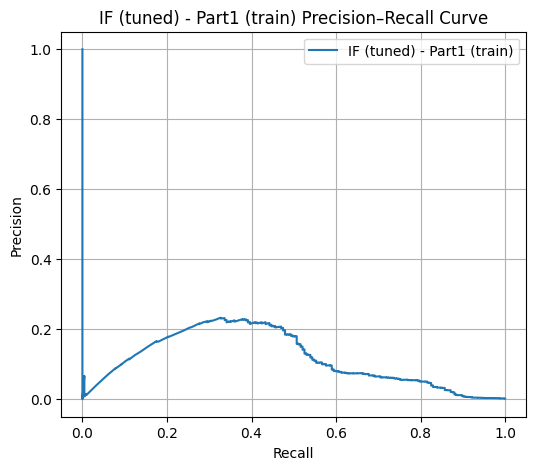

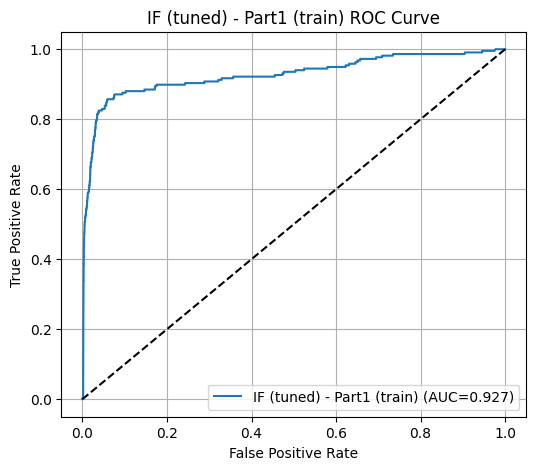


=== Isolation Forest (tuned) - Part2 (test2) ===

=== IF (tuned) - Part2 (test2) ===
Precision: 0.1686
Recall:    0.3791
F1-score:  0.2334
ROC-AUC:   0.6880

Confusion matrix:
[[94497   286]
 [   95    58]]

Classification report:
              precision    recall  f1-score   support

           0     0.9990    0.9970    0.9980     94783
           1     0.1686    0.3791    0.2334       153

    accuracy                         0.9960     94936
   macro avg     0.5838    0.6880    0.6157     94936
weighted avg     0.9977    0.9960    0.9968     94936



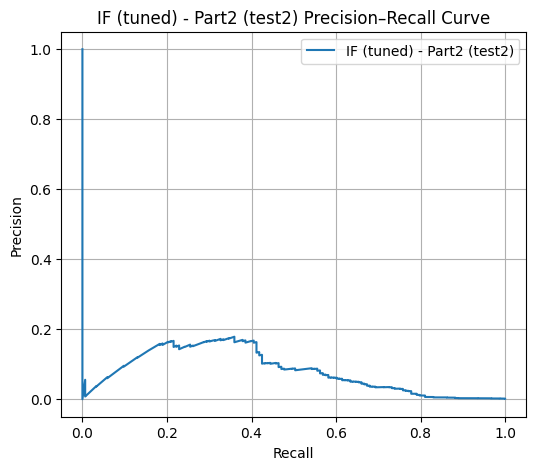

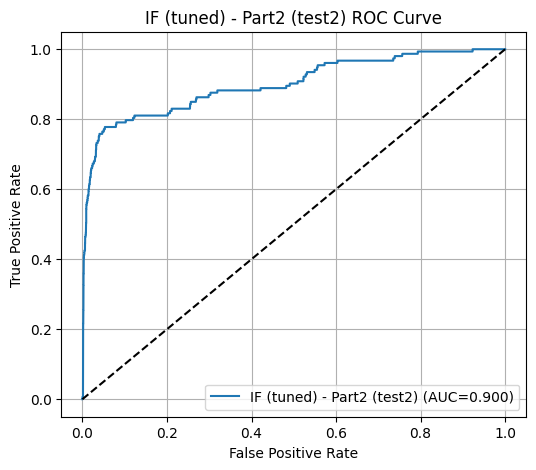


=== Isolation Forest (tuned) - Part3 (test3) ===

=== IF (tuned) - Part3 (test3) ===
Precision: 0.0278
Recall:    0.0984
F1-score:  0.0433
ROC-AUC:   0.5470

Confusion matrix:
[[94393   420]
 [  110    12]]

Classification report:
              precision    recall  f1-score   support

           0     0.9988    0.9956    0.9972     94813
           1     0.0278    0.0984    0.0433       122

    accuracy                         0.9944     94935
   macro avg     0.5133    0.5470    0.5203     94935
weighted avg     0.9976    0.9944    0.9960     94935



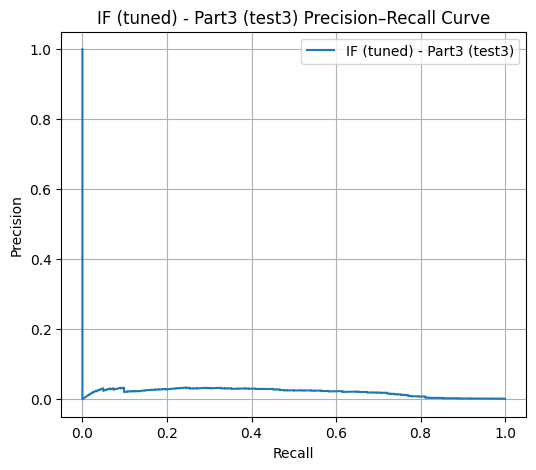

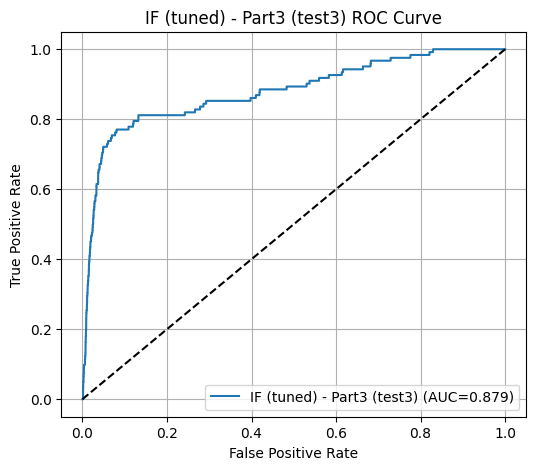

In [8]:
# == Isolation Forest on AE bottleneck (train on Part1 normals only) ==

X_if = X_bottleneck

# Train IF on NORMAL samples from PART 1
train_mask = np.zeros_like(y_true, dtype=bool)
train_mask[idx_train] = True
normal_train_mask_if = (y_true == 0) & train_mask

X_if_train = X_if[normal_train_mask_if]

iso_forest = IsolationForest(
    n_estimators=300,
    contamination=0.002,   # close to true fraud rate
    max_samples=256,
    random_state=42,
    n_jobs=-1,
    bootstrap=False
)

iso_forest.fit(X_if_train)

# Scores on ALL data
iso_scores_raw = iso_forest.decision_function(X_if)  # higher = more normal
iso_scores = -iso_scores_raw                         # higher = more anomalous

# Threshold tuning on PART 1 only
scores_train_if = iso_scores[idx_train]
labels_train_if = y_true[idx_train]

percentiles = np.linspace(90, 99.9, 50)
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train_if, p)
    preds = (scores_train_if > thr).astype(int)
    prec = precision_score(labels_train_if, preds, zero_division=0)
    rec  = recall_score(labels_train_if, preds, zero_division=0)
    f1   = f1_score(labels_train_if, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[IF threshold tuning (Part1 only)]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

iso_thresh = best_thr
y_pred_if_all = (iso_scores > iso_thresh).astype(int)

print(f"\nIF score threshold (tuned): {iso_thresh:.4f}")
print(f"Total IF anomalies: {(y_pred_if_all == 1).sum()} / {len(y_pred_if_all)}")

def eval_if_split(name, sl):
    y_split = y_true[sl]
    s_split = iso_scores[sl]
    y_pred_split = y_pred_if_all[sl]
    print(f"\n=== Isolation Forest (tuned) - {name} ===")
    _ = evaluate_model(f"IF (tuned) - {name}", y_split, y_pred_split)
    plot_curves(f"IF (tuned) - {name}", y_split, s_split)

eval_if_split("Part1 (train)", idx_train)
eval_if_split("Part2 (test2)", idx_test2)
eval_if_split("Part3 (test3)", idx_test3)

# Optional normed score for later ensemble / VQC
iso_score_norm = normalize_scores(iso_scores)


In [9]:
# ============================================
# Supervised Models (LR + RF) on Hybrid Classical Features
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 1) Build hybrid classical feature vector
#    - AE latent (4D)
#    - AE anomaly score (ae_norm)
#    - IF anomaly score (if_norm)

ae_norm = normalize_scores(ae_mse)
if_norm = normalize_scores(iso_scores)

X_hybrid = np.column_stack([
    X_bottleneck,              # 4 latent dims
    ae_norm.reshape(-1, 1),    # 1
    if_norm.reshape(-1, 1),    # 1
])  # shape (N, 6)

y_all = y_true.astype(int)

X_train_sup = X_hybrid[idx_train]
y_train_sup = y_all[idx_train]

print("Hybrid feature shape:", X_hybrid.shape)
print("Train (Part1) shape:", X_train_sup.shape)

# 2) Define supervised models
log_reg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    n_jobs=-1
)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# 3) Train on Part1 only
log_reg.fit(X_train_sup, y_train_sup)
rf_clf.fit(X_train_sup, y_train_sup)

# 4) Get probabilities (fraud scores) on ALL data
lr_probs_all = log_reg.predict_proba(X_hybrid)[:, 1]
rf_probs_all = rf_clf.predict_proba(X_hybrid)[:, 1]

# 5) Create teacher signal (classical ensemble)
teacher_all = 0.5 * lr_probs_all + 0.5 * rf_probs_all

print("Teacher score ready, shape:", teacher_all.shape)


Hybrid feature shape: (284807, 5)
Train (Part1) shape: (94936, 5)
Teacher score ready, shape: (284807,)



[AE+IF Ensemble threshold tuning]
Best percentile: 99.70
Best threshold:  0.2729
Precision:       0.1649
Recall:          0.2886
F1-score:        0.2099

Ensemble threshold (tuned): 0.2729
Ensemble anomalies: 861 / 284807

=== AE+IF Ensemble (tuned) ===
Precision: 0.1649
Recall:    0.2886
F1-score:  0.2099
ROC-AUC:   0.6430

Confusion matrix:
[[283596    719]
 [   350    142]]

Classification report:
              precision    recall  f1-score   support

           0     0.9988    0.9975    0.9981    284315
           1     0.1649    0.2886    0.2099       492

    accuracy                         0.9962    284807
   macro avg     0.5818    0.6430    0.6040    284807
weighted avg     0.9973    0.9962    0.9968    284807



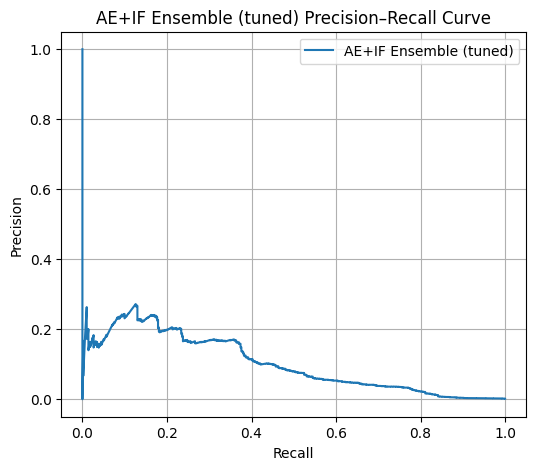

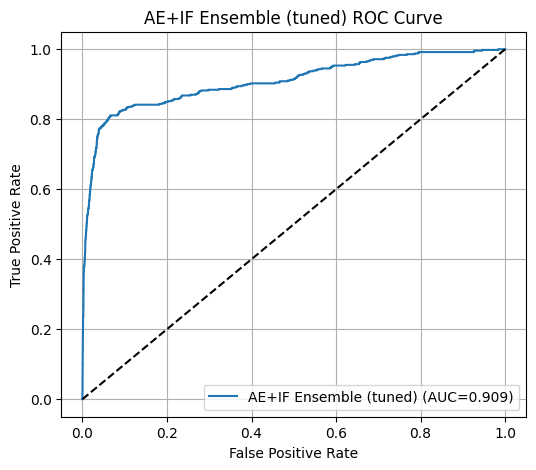

In [10]:
# == Pre-VQC Ensemble: AE + IF ==

# 1) Normalize AE and IF scores (higher = more anomalous)
ae_norm = normalize_scores(ae_mse)      # from AE block
if_norm = normalize_scores(iso_scores)  # from IF block

# Simple fixed weights for now (you can tune later)
w_ae = 0.7
w_if = 0.3

ensemble_scores = w_ae * ae_norm + w_if * if_norm  # higher = more anomalous

# === Threshold tuning for Ensemble (search best percentile by F1) ===
scores = ensemble_scores
labels = y_true  # same as y_true, used in AE block

percentiles = np.linspace(90, 99.9, 50)  # search 90% → 99.9%
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores, p)
    preds = (scores > thr).astype(int)
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score(labels, preds, zero_division=0)
    f1   = f1_score(labels, preds, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[AE+IF Ensemble threshold tuning]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

ens_thresh = best_thr
y_pred_ens = (scores > ens_thresh).astype(int)

print(f"\nEnsemble threshold (tuned): {ens_thresh:.4f}")
print(f"Ensemble anomalies: {(y_pred_ens == 1).sum()} / {len(y_pred_ens)}")

# Metrics and curves for the ensemble
_ = evaluate_model("AE+IF Ensemble (tuned)", labels, y_pred_ens)
plot_curves("AE+IF Ensemble (tuned)", labels, ensemble_scores)

# Optionally store for later use
ensemble_results = {
    "scores": ensemble_scores,
    "threshold": ens_thresh,
    "y_pred": y_pred_ens,
    "ae_norm": ae_norm,
    "if_norm": if_norm,
}

In [11]:
print("X_bottleneck shape:", X_bottleneck.shape)


X_bottleneck shape: (284807, 3)


In [12]:
# =======================================================
# VQC Distillation (2-qubit) from classical teacher (LR+RF)
# =======================================================

'''import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# ---------- 1) Build enriched features and quantum angles ----------

# Uses AE bottleneck + AE score + IF score
ae_norm = normalize_scores(ae_mse)
if_norm = normalize_scores(iso_scores)

X_enriched = np.column_stack([
    X_bottleneck,              # latent (4D)
    ae_norm.reshape(-1, 1),    # 1
    if_norm.reshape(-1, 1),    # 1
])  # shape (N, 6)

pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_enriched)   # (N, 2)

# Scale to [-pi, pi] for angle embedding
min_v = X_pca2.min(axis=0)
max_v = X_pca2.max(axis=0)
X_q_angles = ((X_pca2 - min_v) / (max_v - min_v + 1e-12)) * (2 * np.pi) - np.pi

# Teacher signal from supervised models (already computed in previous cell)
y_teacher = teacher_all.astype(np.float32)

# ---------- 2) Small training subset (Part1 only) ----------

idx1 = np.arange(idx_train.start, idx_train.stop)

fraud_idx_1  = idx1[y_true[idx_train] == 1]
normal_idx_1 = idx1[y_true[idx_train] == 0]

rng = np.random.default_rng(42)
n_normals_sample = min(800, len(normal_idx_1))
normal_sample_1  = rng.choice(normal_idx_1, size=n_normals_sample, replace=False)

sel_idx = np.concatenate([fraud_idx_1, normal_sample_1])
X_vqc_sel = X_q_angles[sel_idx]
t_vqc_sel = y_teacher[sel_idx]

print("VQC distill train subset shape:", X_vqc_sel.shape)
print("Teacher stats on subset: min=", t_vqc_sel.min(), "max=", t_vqc_sel.max())

X_train_q, X_val_q, t_train_q, t_val_q = train_test_split(
    X_vqc_sel, t_vqc_sel,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_train_t = torch.tensor(X_train_q, dtype=torch.float32)
t_train_t = torch.tensor(t_train_q, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val_q, dtype=torch.float32)
t_val_t = torch.tensor(t_val_q, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, t_train_t)
val_ds   = TensorDataset(X_val_t, t_val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)

# ---------- 3) Define 2-qubit VQC regressor ----------

n_qubits = 2

feature_map_vqc = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
ansatz_vqc = TwoLocal(
    n_qubits,
    rotation_blocks=['ry', 'rz'],
    entanglement_blocks='cx',
    reps=1
)
vqc_circuit = feature_map_vqc.compose(ansatz_vqc)

estimator = Estimator()
observable_vqc = SparsePauliOp('Z' * n_qubits)  # "ZZ"

vqc_qnn = EstimatorQNN(
    circuit=vqc_circuit,
    estimator=estimator,
    observables=[observable_vqc],
    input_params=feature_map_vqc.parameters,
    weight_params=ansatz_vqc.parameters,
)

vqc_torch = TorchConnector(vqc_qnn)


class VQCRegressor(nn.Module):
    """
    VQC that outputs a scalar in [0,1] trying to match teacher_all.
    """
    def __init__(self, vqc_module):
        super().__init__()
        self.vqc = vqc_module
        self.fc  = nn.Linear(1, 1)

    def forward(self, x):
        q_out = self.vqc(x)  # (batch,) or (batch,1) in [-1,1]
        if q_out.dim() == 1:
            q_out = q_out.view(-1, 1)
        x01 = (q_out + 1.0) / 2.0      # [-1,1] -> [0,1]
        out = torch.sigmoid(self.fc(x01))
        return out  # (batch,1)


vqc_model = VQCRegressor(vqc_torch)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vqc_model.parameters(), lr=1e-3)

# ---------- 4) Train VQC (distilling teacher_all) ----------

num_epochs = 5

for epoch in range(num_epochs):
    vqc_model.train()
    train_loss = 0.0
    for xb, tb in train_loader:
        optimizer.zero_grad()
        pred = vqc_model(xb)
        loss = criterion(pred, tb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    vqc_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, tb in val_loader:
            pred = vqc_model(xb)
            loss = criterion(pred, tb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - train_loss={train_loss:.4f} - val_loss={val_loss:.4f}")

# ---------- 5) Get VQC scores on ALL samples ----------

vqc_model.eval()
with torch.no_grad():
    X_all_t = torch.tensor(X_q_angles, dtype=torch.float32)
    vqc_pred_all = vqc_model(X_all_t).cpu().numpy().reshape(-1)

vqc_scores = vqc_pred_all           # in [0,1], mimicking teacher_all
vqc_norm   = normalize_scores(vqc_scores)

# Check distillation quality on Part1
mse_part1 = np.mean((vqc_scores[idx_train] - teacher_all[idx_train])**2)
print(f"\n[VQC distillation] MSE on Part1 vs teacher: {mse_part1:.6f}")

# ---------- 6) Turn VQC score into anomaly detector ----------

scores_train_vqc = vqc_scores[idx_train]
labels_train_vqc = y_true[idx_train]

percentiles = np.linspace(90, 99.9, 50)
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train_vqc, p)
    preds = (scores_train_vqc > thr).astype(int)
    prec = precision_score(labels_train_vqc, preds, zero_division=0)
    rec  = recall_score(labels_train_vqc, preds, zero_division=0)
    f1   = f1_score(labels_train_vqc, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[VQC (distilled) threshold tuning - Part1 only]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

vqc_thr = best_thr
y_pred_vqc_all = (vqc_scores > vqc_thr).astype(int)

print(f"\nVQC (distilled) anomalies: {(y_pred_vqc_all == 1).sum()} / {len(y_pred_vqc_all)}")

def eval_vqc_split(name, sl):
    y_split = y_true[sl]
    s_split = vqc_scores[sl]
    y_pred_split = y_pred_vqc_all[sl]
    print(f"\n=== VQC (distilled from LR+RF) - {name} ===")
    _ = evaluate_model(f"VQC (distilled) - {name}", y_split, y_pred_split)
    plot_curves(f"VQC (distilled) - {name}", y_split, s_split)

eval_vqc_split("Part1 (train)", idx_train)
eval_vqc_split("Part2 (test2)", idx_test2)
eval_vqc_split("Part3 (test3)", idx_test3)'''


'import numpy as np\nimport torch\nimport torch.nn as nn\nfrom torch.utils.data import TensorDataset, DataLoader\nfrom sklearn.decomposition import PCA\nfrom sklearn.model_selection import train_test_split\n\nfrom qiskit.circuit.library import ZZFeatureMap, TwoLocal\nfrom qiskit.primitives import Estimator\nfrom qiskit.quantum_info import SparsePauliOp\nfrom qiskit_machine_learning.neural_networks import EstimatorQNN\nfrom qiskit_machine_learning.connectors import TorchConnector\n\n# ---------- 1) Build enriched features and quantum angles ----------\n\n# Uses AE bottleneck + AE score + IF score\nae_norm = normalize_scores(ae_mse)\nif_norm = normalize_scores(iso_scores)\n\nX_enriched = np.column_stack([\n    X_bottleneck,              # latent (4D)\n    ae_norm.reshape(-1, 1),    # 1\n    if_norm.reshape(-1, 1),    # 1\n])  # shape (N, 6)\n\npca_2 = PCA(n_components=2, random_state=42)\nX_pca2 = pca_2.fit_transform(X_enriched)   # (N, 2)\n\n# Scale to [-pi, pi] for angle embedding\nmin

VQC v3 train subset shape: (970, 2)
Frauds in subset: 370 Normals: 600
Epoch 1/8 - train_loss=0.7399 - val_loss=0.7114
Epoch 2/8 - train_loss=0.7275 - val_loss=0.7018
Epoch 3/8 - train_loss=0.7170 - val_loss=0.6917
Epoch 4/8 - train_loss=0.7062 - val_loss=0.6825
Epoch 5/8 - train_loss=0.6961 - val_loss=0.6735
Epoch 6/8 - train_loss=0.6865 - val_loss=0.6631
Epoch 7/8 - train_loss=0.6758 - val_loss=0.6540
Epoch 8/8 - train_loss=0.6662 - val_loss=0.6441

[VQC v3 (2-qubit) threshold tuning - Part1 only]
Best percentile: 98.52
Best threshold:  0.3485
Precision:       0.0582
Recall:          0.3779
F1-score:        0.1009

VQC v3 (2-qubit) anomalies: 4179 / 284807

=== VQC v3 (2-qubit enriched+teacher) - Part1 (train) ===

=== VQC v3 (2-qubit enriched+teacher) - Part1 (train) ===
Precision: 0.0582
Recall:    0.3779
F1-score:  0.1009
ROC-AUC:   0.6819

Confusion matrix:
[[93393  1326]
 [  135    82]]

Classification report:
              precision    recall  f1-score   support

           0  

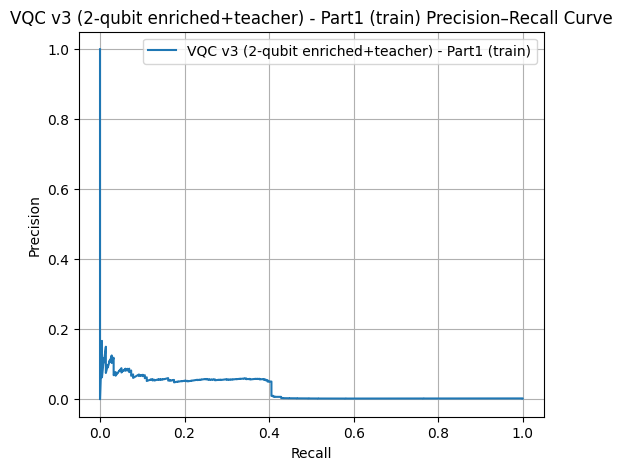

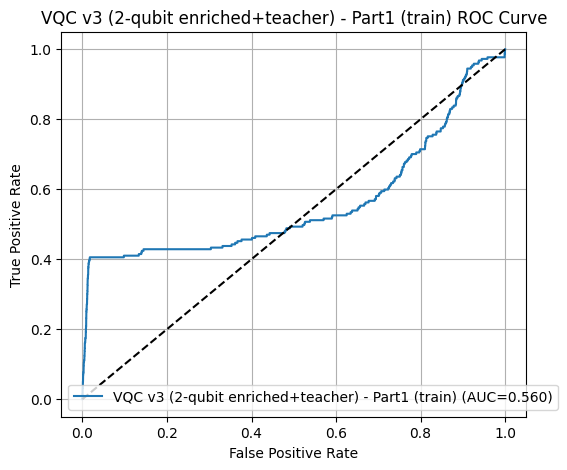


=== VQC v3 (2-qubit enriched+teacher) - Part2 (test2) ===

=== VQC v3 (2-qubit enriched+teacher) - Part2 (test2) ===
Precision: 0.0430
Recall:    0.3725
F1-score:  0.0770
ROC-AUC:   0.6796

Confusion matrix:
[[93513  1270]
 [   96    57]]

Classification report:
              precision    recall  f1-score   support

           0     0.9990    0.9866    0.9927     94783
           1     0.0430    0.3725    0.0770       153

    accuracy                         0.9856     94936
   macro avg     0.5210    0.6796    0.5349     94936
weighted avg     0.9974    0.9856    0.9913     94936



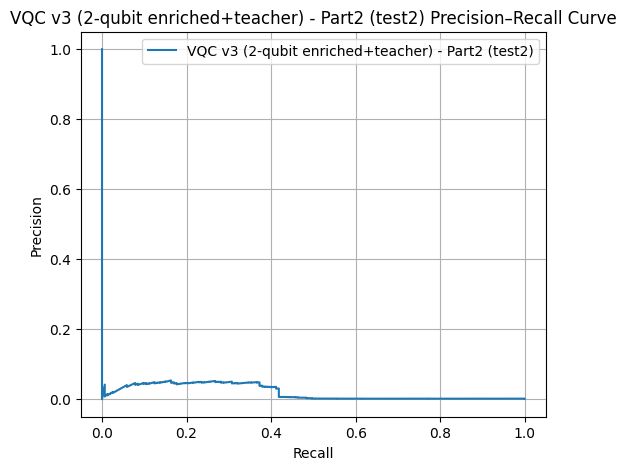

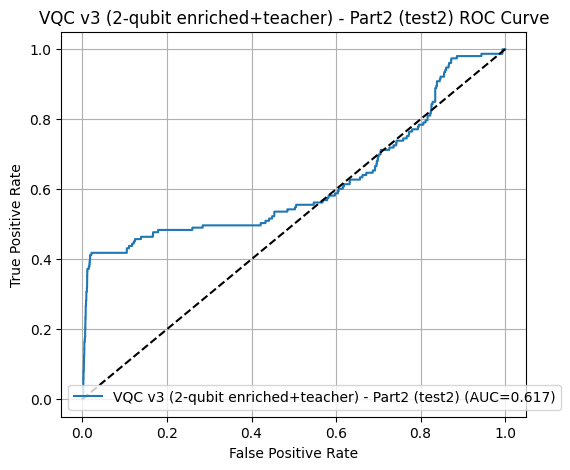


=== VQC v3 (2-qubit enriched+teacher) - Part3 (test3) ===

=== VQC v3 (2-qubit enriched+teacher) - Part3 (test3) ===
Precision: 0.0159
Recall:    0.1885
F1-score:  0.0294
ROC-AUC:   0.5868

Confusion matrix:
[[93392  1421]
 [   99    23]]

Classification report:
              precision    recall  f1-score   support

           0     0.9989    0.9850    0.9919     94813
           1     0.0159    0.1885    0.0294       122

    accuracy                         0.9840     94935
   macro avg     0.5074    0.5868    0.5107     94935
weighted avg     0.9977    0.9840    0.9907     94935



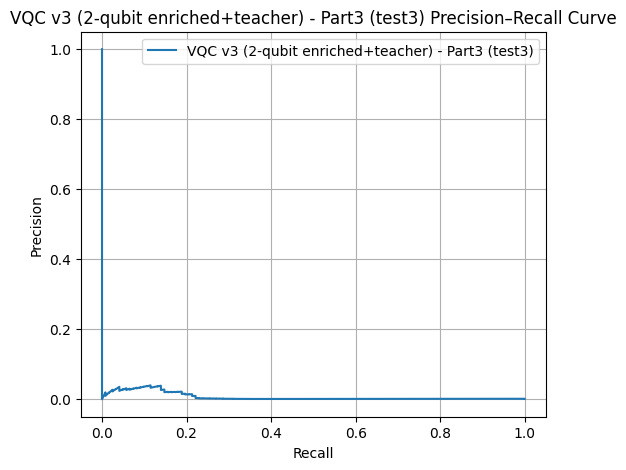

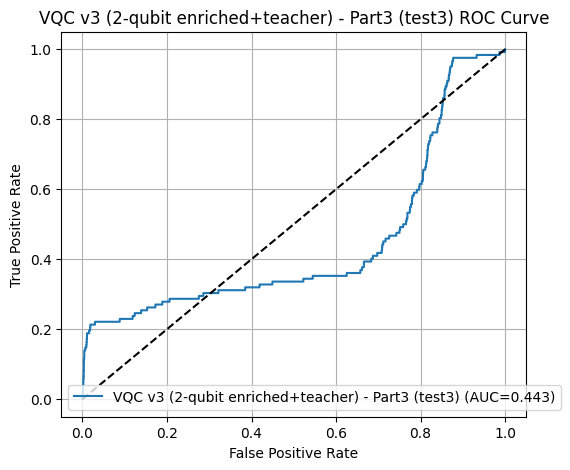

In [13]:
# =======================================================
# VQC v3: 2-qubit enriched classifier using teacher as feature
# =======================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# ---------- 1) Enriched features (latent + AE + IF + teacher) ----------

ae_norm = normalize_scores(ae_mse)
if_norm = normalize_scores(iso_scores)

# Enriched classical feature space for quantum model:
#   - AE latent (4)
#   - AE anomaly score (1)
#   - IF anomaly score (1)
#   - Teacher score from LR+RF (1)
X_enriched_q = np.column_stack([
    X_bottleneck,                 # 4
    ae_norm.reshape(-1, 1),       # 1
    if_norm.reshape(-1, 1),       # 1
    teacher_all.reshape(-1, 1),   # 1
])  # shape (N, 7)

y_all = y_true.astype(np.float32)

# PCA -> 2 dims for 2-qubit circuit
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_enriched_q)   # shape (N,2)

# Scale to [-pi, pi] for angle embedding
min_v = X_pca2.min(axis=0)
max_v = X_pca2.max(axis=0)
X_q_angles = ((X_pca2 - min_v) / (max_v - min_v + 1e-12)) * (2 * np.pi) - np.pi

# ---------- 2) Build SMALL training subset from Part1 + Part2 ----------

idx1 = np.arange(idx_train.start, idx_train.stop)
idx2 = np.arange(idx_test2.start, idx_test2.stop)

y_part1 = y_all[idx_train]
y_part2 = y_all[idx_test2]

fraud_idx_1  = idx1[y_part1 == 1]
fraud_idx_2  = idx2[y_part2 == 1]
normal_idx_1 = idx1[y_part1 == 0]
normal_idx_2 = idx2[y_part2 == 0]

rng = np.random.default_rng(42)

n_normals_1 = min(300, len(normal_idx_1))
n_normals_2 = min(300, len(normal_idx_2))

normal_sample_1 = rng.choice(normal_idx_1, size=n_normals_1, replace=False)
normal_sample_2 = rng.choice(normal_idx_2, size=n_normals_2, replace=False)

sel_idx = np.concatenate([
    fraud_idx_1,
    fraud_idx_2,
    normal_sample_1,
    normal_sample_2
])

X_vqc_sel = X_q_angles[sel_idx]
y_vqc_sel = y_all[sel_idx]

print("VQC v3 train subset shape:", X_vqc_sel.shape)
print("Frauds in subset:", (y_vqc_sel == 1).sum(),
      "Normals:", (y_vqc_sel == 0).sum())

# Train/val split on this subset
X_train_q, X_val_q, y_train_q, y_val_q = train_test_split(
    X_vqc_sel, y_vqc_sel,
    test_size=0.2,
    stratify=y_vqc_sel,
    random_state=42
)

X_train_t = torch.tensor(X_train_q, dtype=torch.float32)
y_train_t = torch.tensor(y_train_q, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val_q, dtype=torch.float32)
y_val_t = torch.tensor(y_val_q, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)

# ---------- 3) 2-qubit VQC classifier ----------

n_qubits = 2

feature_map_vqc = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
ansatz_vqc = TwoLocal(
    n_qubits,
    rotation_blocks=['ry', 'rz'],
    entanglement_blocks='cx',
    reps=2
)
vqc_circuit = feature_map_vqc.compose(ansatz_vqc)

estimator = Estimator()
observable_vqc = SparsePauliOp('Z' * n_qubits)

vqc_qnn = EstimatorQNN(
    circuit=vqc_circuit,
    estimator=estimator,
    observables=[observable_vqc],
    input_params=feature_map_vqc.parameters,
    weight_params=ansatz_vqc.parameters,
)

vqc_torch = TorchConnector(vqc_qnn)


class VQCClassifier(nn.Module):
    def __init__(self, vqc_module):
        super().__init__()
        self.vqc = vqc_module

    def forward(self, x):
        q_out = self.vqc(x)  # (batch,) or (batch,1) in [-1,1]
        if q_out.dim() == 1:
            q_out = q_out.view(-1, 1)
        p = (q_out + 1.0) / 2.0
        p = torch.clamp(p, 1e-6, 1.0 - 1e-6)
        logits = torch.log(p / (1.0 - p))
        return logits


vqc_model = VQCClassifier(vqc_torch)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(vqc_model.parameters(), lr=1e-3)

# ---------- 4) Train VQC v3 (classification) ----------

num_epochs = 8   # you can test 3–8

for epoch in range(num_epochs):
    vqc_model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = vqc_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    vqc_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = vqc_model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - train_loss={train_loss:.4f} - val_loss={val_loss:.4f}")

# ---------- 5) VQC scores on ALL data ----------

vqc_model.eval()
with torch.no_grad():
    X_all_t = torch.tensor(X_q_angles, dtype=torch.float32)
    logits_all = vqc_model(X_all_t)
    probs_all = torch.sigmoid(logits_all).cpu().numpy().reshape(-1)

vqc_scores = probs_all
vqc_norm   = normalize_scores(vqc_scores)

# ---------- 6) Threshold tuning on Part1 only ----------

scores_train_vqc = vqc_scores[idx_train]
labels_train_vqc = y_true[idx_train]

percentiles = np.linspace(85, 99.5, 60)
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_train_vqc, p)
    preds = (scores_train_vqc > thr).astype(int)
    prec = precision_score(labels_train_vqc, preds, zero_division=0)
    rec  = recall_score(labels_train_vqc, preds, zero_division=0)
    f1   = f1_score(labels_train_vqc, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[VQC v3 (2-qubit) threshold tuning - Part1 only]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

vqc_thresh = best_thr
y_pred_vqc_all = (vqc_scores > vqc_thresh).astype(int)

print(f"\nVQC v3 (2-qubit) anomalies: {(y_pred_vqc_all == 1).sum()} / {len(y_pred_vqc_all)}")

# ---------- 7) Evaluate by part ----------

def eval_vqc_split(name, sl):
    y_split = y_true[sl]
    s_split = vqc_scores[sl]
    y_pred_split = y_pred_vqc_all[sl]
    print(f"\n=== VQC v3 (2-qubit enriched+teacher) - {name} ===")
    _ = evaluate_model(f"VQC v3 (2-qubit enriched+teacher) - {name}", y_split, y_pred_split)
    plot_curves(f"VQC v3 (2-qubit enriched+teacher) - {name}", y_split, s_split)

eval_vqc_split("Part1 (train)", idx_train)
eval_vqc_split("Part2 (test2)", idx_test2)
eval_vqc_split("Part3 (test3)", idx_test3)


Score stats:
  AE:      min= 0.0 max= 0.9999999999999992
  Teacher: min= 0.0 max= 0.999999999998999
  VQC v3:  min= 0.0 max= 1.0

[Final Ensemble - best config (Part1 tuning)]
Weights: AE=0.70, Teacher=0.30, VQC=0.00
Best percentile: 99.70
Best threshold:  0.2473
Precision:       0.5958
Recall:          0.7880
F1-score:        0.6786

Total ensemble anomalies: 890 / 284807

=== Final Ensemble (AE+Teacher+VQC) - Part1 (train) ===

=== Final Ensemble - Part1 (train) ===
Precision: 0.5958
Recall:    0.7880
F1-score:  0.6786
ROC-AUC:   0.8934

Confusion matrix:
[[94603   116]
 [   46   171]]

Classification report:
              precision    recall  f1-score   support

           0     0.9995    0.9988    0.9991     94719
           1     0.5958    0.7880    0.6786       217

    accuracy                         0.9983     94936
   macro avg     0.7977    0.8934    0.8389     94936
weighted avg     0.9986    0.9983    0.9984     94936



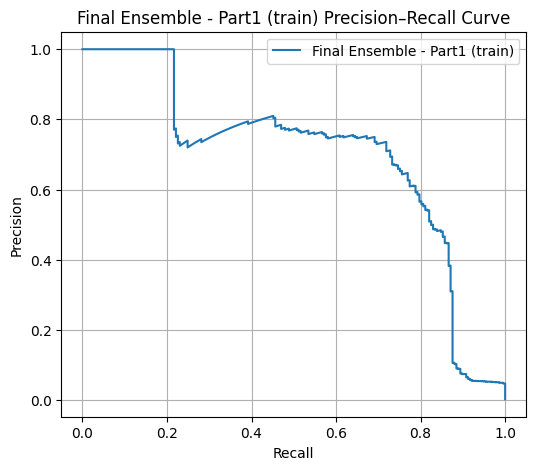

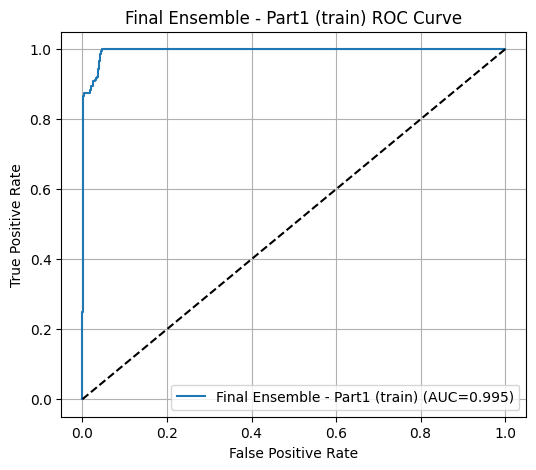


=== Final Ensemble (AE+Teacher+VQC) - Part2 (test2) ===

=== Final Ensemble - Part2 (test2) ===
Precision: 0.3472
Recall:    0.6536
F1-score:  0.4535
ROC-AUC:   0.8258

Confusion matrix:
[[94595   188]
 [   53   100]]

Classification report:
              precision    recall  f1-score   support

           0     0.9994    0.9980    0.9987     94783
           1     0.3472    0.6536    0.4535       153

    accuracy                         0.9975     94936
   macro avg     0.6733    0.8258    0.7261     94936
weighted avg     0.9984    0.9975    0.9978     94936



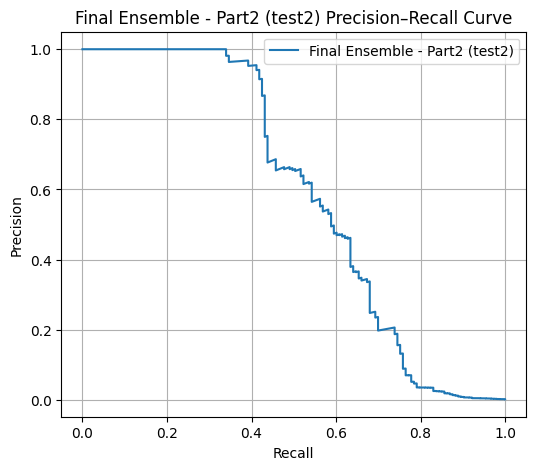

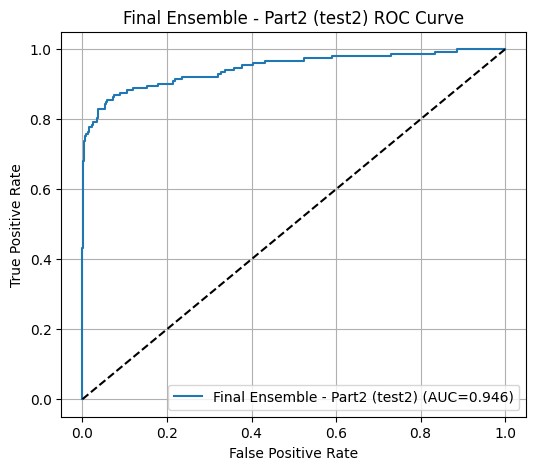


=== Final Ensemble (AE+Teacher+VQC) - Part3 (test3) ===

=== Final Ensemble - Part3 (test3) ===
Precision: 0.2349
Recall:    0.6066
F1-score:  0.3387
ROC-AUC:   0.8020

Confusion matrix:
[[94572   241]
 [   48    74]]

Classification report:
              precision    recall  f1-score   support

           0     0.9995    0.9975    0.9985     94813
           1     0.2349    0.6066    0.3387       122

    accuracy                         0.9970     94935
   macro avg     0.6172    0.8020    0.6686     94935
weighted avg     0.9985    0.9970    0.9976     94935



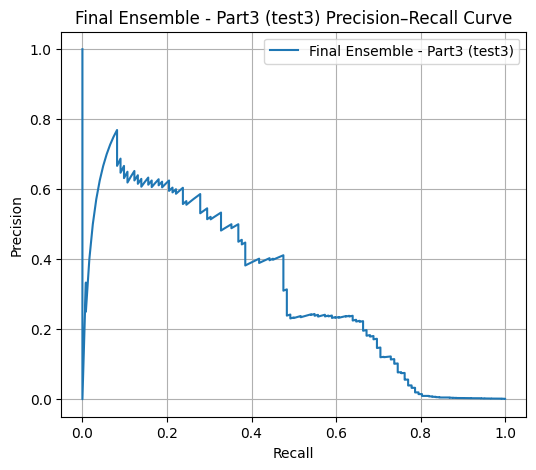

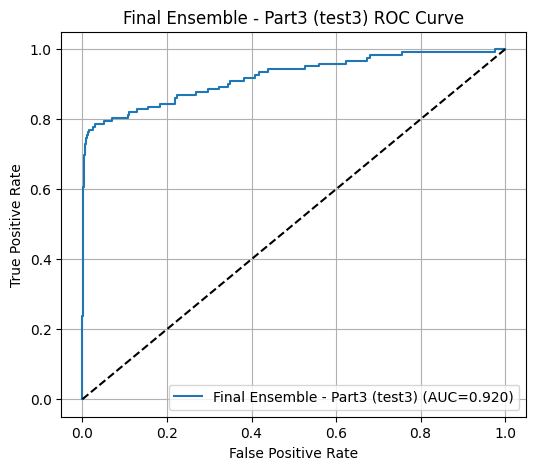

In [14]:
# =======================================================
# Final Hybrid Ensemble: AE + Teacher(LR+RF) + VQC v3
# =======================================================

# We assume these already exist:
#   ae_mse, teacher_all, vqc_scores, y_true
#   idx_train, idx_test2, idx_test3
#   normalize_scores, evaluate_model, plot_curves

# 1) Normalize component scores
ae_norm      = normalize_scores(ae_mse)
teacher_norm = normalize_scores(teacher_all)
vqc_norm     = normalize_scores(vqc_scores)

print("Score stats:")
print("  AE:      min=", ae_norm.min(),      "max=", ae_norm.max())
print("  Teacher: min=", teacher_norm.min(), "max=", teacher_norm.max())
print("  VQC v3:  min=", vqc_norm.min(),     "max=", vqc_norm.max())

y_all = y_true.astype(int)

# 2) Define a small grid of weights for [AE, Teacher, VQC]
w_ae_list      = [0.4, 0.5, 0.6, 0.7]
w_teacher_list = [0.1, 0.2, 0.3]

best_cfg = None
best_f1  = -1.0

percentiles = np.linspace(90, 99.9, 50)

# 3) Search weight combos + threshold (Part1 only)
scores_part1_ae      = ae_norm[idx_train]
scores_part1_teacher = teacher_norm[idx_train]
scores_part1_vqc     = vqc_norm[idx_train]
labels_part1         = y_all[idx_train]

for w_ae in w_ae_list:
    for w_teacher in w_teacher_list:
        w_vqc = 1.0 - w_ae - w_teacher
        if w_vqc < 0:
            continue  # skip invalid combos

        ensemble_part1 = (
            w_ae      * scores_part1_ae +
            w_teacher * scores_part1_teacher +
            w_vqc     * scores_part1_vqc
        )

        for p in percentiles:
            thr = np.percentile(ensemble_part1, p)
            preds = (ensemble_part1 > thr).astype(int)

            prec = precision_score(labels_part1, preds, zero_division=0)
            rec  = recall_score(labels_part1, preds, zero_division=0)
            f1   = f1_score(labels_part1, preds, zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_cfg = {
                    "w_ae": w_ae,
                    "w_teacher": w_teacher,
                    "w_vqc": w_vqc,
                    "percentile": p,
                    "threshold": thr,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1,
                }

print("\n[Final Ensemble - best config (Part1 tuning)]")
print(f"Weights: AE={best_cfg['w_ae']:.2f}, "
      f"Teacher={best_cfg['w_teacher']:.2f}, "
      f"VQC={best_cfg['w_vqc']:.2f}")
print(f"Best percentile: {best_cfg['percentile']:.2f}")
print(f"Best threshold:  {best_cfg['threshold']:.4f}")
print(f"Precision:       {best_cfg['precision']:.4f}")
print(f"Recall:          {best_cfg['recall']:.4f}")
print(f"F1-score:        {best_cfg['f1']:.4f}")

# 4) Build final ensemble score for ALL samples with best weights
w_ae_best      = best_cfg['w_ae']
w_teacher_best = best_cfg['w_teacher']
w_vqc_best     = best_cfg['w_vqc']
thr_best       = best_cfg['threshold']

ensemble_all = (
    w_ae_best      * ae_norm +
    w_teacher_best * teacher_norm +
    w_vqc_best     * vqc_norm
)

y_pred_ensemble_all = (ensemble_all > thr_best).astype(int)

print(f"\nTotal ensemble anomalies: "
      f"{(y_pred_ensemble_all == 1).sum()} / {len(y_pred_ensemble_all)}")

# 5) Evaluate ensemble on Part1 / Part2 / Part3
def eval_ensemble_split(name, sl):
    y_split = y_all[sl]
    s_split = ensemble_all[sl]
    y_pred_split = y_pred_ensemble_all[sl]
    print(f"\n=== Final Ensemble (AE+Teacher+VQC) - {name} ===")
    _ = evaluate_model(f"Final Ensemble - {name}", y_split, y_pred_split)
    plot_curves(f"Final Ensemble - {name}", y_split, s_split)

eval_ensemble_split("Part1 (train)", idx_train)
eval_ensemble_split("Part2 (test2)", idx_test2)
eval_ensemble_split("Part3 (test3)", idx_test3)


Soft-gated: samples in uncertainty band: 1014 / 284807

[Soft-Gated Ensemble v2 - Part1 tuning]
Best percentile: 99.50
Best threshold:  0.1799
Precision:       0.3925
Recall:          0.8664
F1-score:        0.5402

Total anomalies (soft-gated ensemble): 1652 / 284807

=== Soft-Gated Ensemble v2 - Part1 (train) ===

=== Soft-Gated Ensemble v2 - Part1 (train) ===
Precision: 0.3925
Recall:    0.8664
F1-score:  0.5402
ROC-AUC:   0.9316

Confusion matrix:
[[94428   291]
 [   29   188]]

Classification report:
              precision    recall  f1-score   support

           0     0.9997    0.9969    0.9983     94719
           1     0.3925    0.8664    0.5402       217

    accuracy                         0.9966     94936
   macro avg     0.6961    0.9316    0.7693     94936
weighted avg     0.9983    0.9966    0.9973     94936



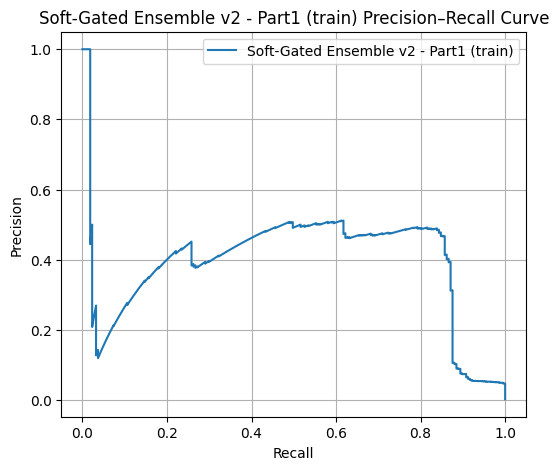

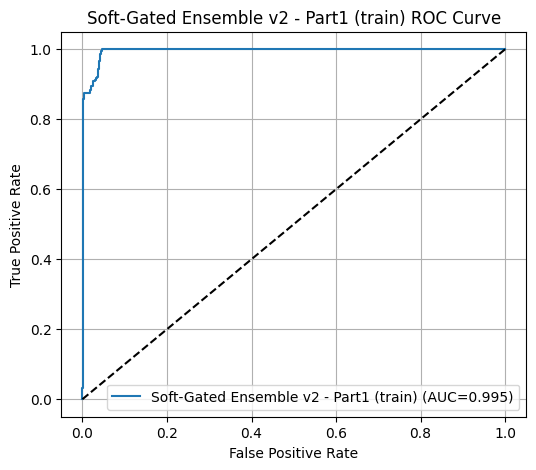

Samples inside uncertainty band in Part1 (train): 246 / 94936

=== Soft-Gated Ensemble v2 - Part2 (test2) ===

=== Soft-Gated Ensemble v2 - Part2 (test2) ===
Precision: 0.2077
Recall:    0.7386
F1-score:  0.3242
ROC-AUC:   0.8670

Confusion matrix:
[[94352   431]
 [   40   113]]

Classification report:
              precision    recall  f1-score   support

           0     0.9996    0.9955    0.9975     94783
           1     0.2077    0.7386    0.3242       153

    accuracy                         0.9950     94936
   macro avg     0.6036    0.8670    0.6609     94936
weighted avg     0.9983    0.9950    0.9964     94936



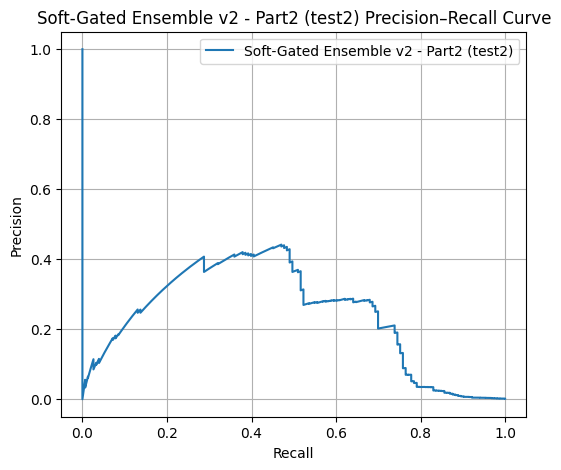

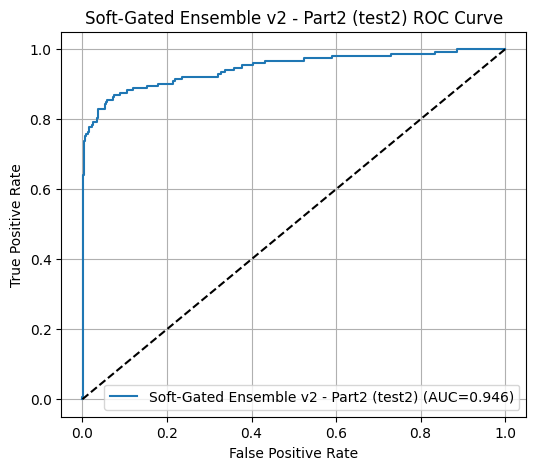

Samples inside uncertainty band in Part2 (test2): 343 / 94936

=== Soft-Gated Ensemble v2 - Part3 (test3) ===

=== Soft-Gated Ensemble v2 - Part3 (test3) ===
Precision: 0.1351
Recall:    0.6967
F1-score:  0.2264
ROC-AUC:   0.8455

Confusion matrix:
[[94269   544]
 [   37    85]]

Classification report:
              precision    recall  f1-score   support

           0     0.9996    0.9943    0.9969     94813
           1     0.1351    0.6967    0.2264       122

    accuracy                         0.9939     94935
   macro avg     0.5674    0.8455    0.6116     94935
weighted avg     0.9985    0.9939    0.9959     94935



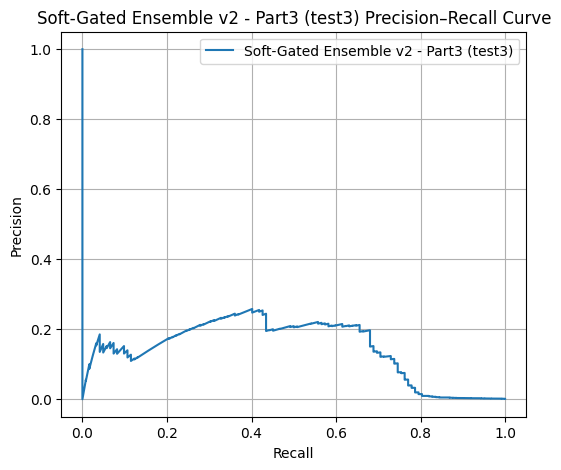

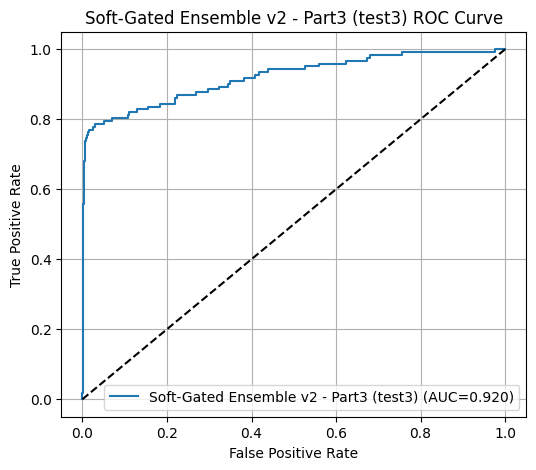

Samples inside uncertainty band in Part3 (test3): 425 / 94935


In [18]:
# =======================================================
# Soft-Gated Ensemble v2: AE+Teacher base, VQC blended on uncertain cases
# =======================================================

# Assumes:
#   ensemble_all   -> base AE+Teacher score (0-1)
#   thr_best       -> best threshold for base ensemble (from best_cfg)
#   vqc_scores     -> VQC v3 fraud probabilities (0-1)
#   y_true, idx_train, idx_test2, idx_test3
#   normalize_scores, evaluate_model, plot_curves

y_all = y_true.astype(int)

base_score = ensemble_all
base_thr   = thr_best

# Normalize VQC scores to match scale (0-1 but smoother)
vqc_norm = normalize_scores(vqc_scores)

# 1) Define uncertainty band and blending strength
uncertainty_margin = 0.05   # widen band → more samples affected by VQC
alpha_vqc = 0.3             # how much VQC pulls the score in uncertain band

uncertain_mask = np.abs(base_score - base_thr) <= uncertainty_margin
print(f"Soft-gated: samples in uncertainty band: {uncertain_mask.sum()} / {len(base_score)}")

# 2) Build soft-gated score:
#    - Outside band: use base_score as-is
#    - Inside band: blend base_score and vqc_norm
gated_score = base_score.copy()
gated_score[uncertain_mask] = (
    (1.0 - alpha_vqc) * base_score[uncertain_mask] +
    alpha_vqc         * vqc_norm[uncertain_mask]
)

# 3) Threshold tuning on Part1 only for the new gated score

scores_part1 = gated_score[idx_train]
labels_part1 = y_all[idx_train]

percentiles = np.linspace(90, 99.9, 50)
best_f1 = -1
best_p = None
best_thr = None
best_prec = None
best_rec = None

for p in percentiles:
    thr = np.percentile(scores_part1, p)
    preds = (scores_part1 > thr).astype(int)
    prec = precision_score(labels_part1, preds, zero_division=0)
    rec  = recall_score(labels_part1, preds, zero_division=0)
    f1   = f1_score(labels_part1, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_thr = thr
        best_prec = prec
        best_rec = rec

print(f"\n[Soft-Gated Ensemble v2 - Part1 tuning]")
print(f"Best percentile: {best_p:.2f}")
print(f"Best threshold:  {best_thr:.4f}")
print(f"Precision:       {best_prec:.4f}")
print(f"Recall:          {best_rec:.4f}")
print(f"F1-score:        {best_f1:.4f}")

gated_thr = best_thr
y_pred_gated_all = (gated_score > gated_thr).astype(int)

print(f"\nTotal anomalies (soft-gated ensemble): "
      f"{(y_pred_gated_all == 1).sum()} / {len(y_pred_gated_all)}")

# 4) Evaluate by split

def eval_soft_gated_split(name, sl):
    y_split = y_all[sl]
    s_split = gated_score[sl]
    y_pred_split = y_pred_gated_all[sl]
    print(f"\n=== Soft-Gated Ensemble v2 - {name} ===")
    _ = evaluate_model(f"Soft-Gated Ensemble v2 - {name}", y_split, y_pred_split)
    plot_curves(f"Soft-Gated Ensemble v2 - {name}", y_split, s_split)

    routed = uncertain_mask[sl].sum()
    print(f"Samples inside uncertainty band in {name}: {routed} / {len(y_split)}")

eval_soft_gated_split("Part1 (train)", idx_train)
eval_soft_gated_split("Part2 (test2)", idx_test2)
eval_soft_gated_split("Part3 (test3)", idx_test3)
